# LAB 3

In [1]:
import warnings
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

In [2]:
# import MNIST dataset from openml not as frame
mnist = fetch_openml('mnist_784', as_frame=False)
# create X and y from mnist, X is the data, y is the target, 70000 images
# each image is 28x28 pixels, each feature simply represents one pixel's intensity, from 0 (white) to 255 (black)
X, y = mnist.data, mnist.target
# split the data into training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [3]:
# create a 5-detector, a binary classifier, 
# capable of distinguishing between just two classes, 5 and not 5
# create target vectors for this classification task
# True for all 5s, False for all other digits
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [4]:
# create a SGDClassifier and train it on the whole training set
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

# Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor.

## Measuring Accuracy Using Cross-Validation

In [5]:
# compute the accuracy of this classifier using cross-validation with 3 folds
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

## Confusion Matrices

In [6]:
# use cross_val_predict() function to perform K-fold cross-validation
# but instead of returning the evaluation scores, 
# return the predictions made on each test fold
# obtaining a prediction for each instance in the training set
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_pred)

[ True False False ...  True False False]


True Positive (Top Left): $\hat{y} = 1 $ and $y = 1$ 

True Negative (Bottom Right): $\hat{y} = -1 $ and $y = -1$ 

False Positive (Bottom Left): $\hat{y} = 1 $ and $y = -1$ 

False Negative (Top Right): $\hat{y} = -1 $ and $y = 1$ 

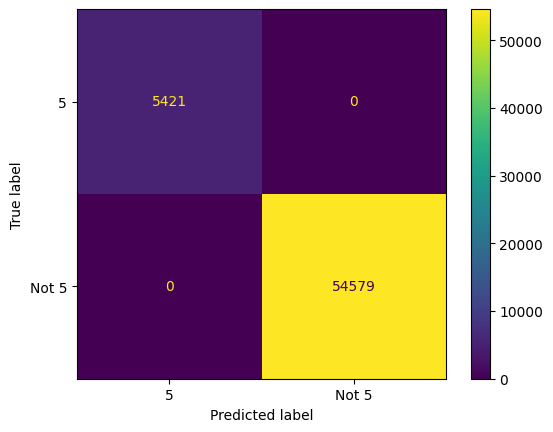

In [7]:
# pretend we reached perfection
# create a confusion matrix for perfect predictions
y_train_perfect_predictions = y_train_5 # pretend we reached perfection

cm = confusion_matrix(y_train_5, y_train_perfect_predictions, labels=[True, False])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['5','Not 5'])
disp.plot()
plt.show()

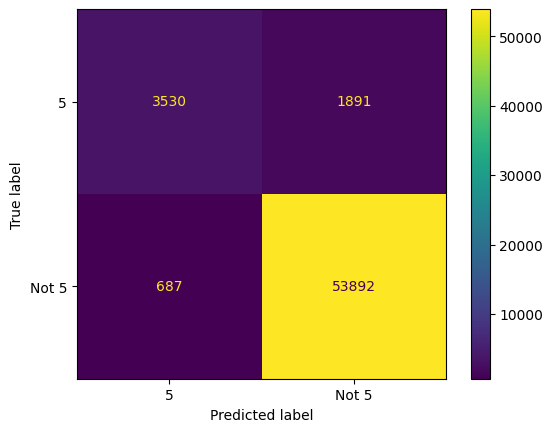

In [8]:
# Let's look at the confusion matrix for our predictions
cm = confusion_matrix(y_train_5, y_train_pred, labels=[True, False])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['5','Not 5'])
disp.plot()
plt.show()

## Precision and Recall


$$ 
\text{precision} = \frac{TP}{TP+FP}
$$


$$
 \text{recall} = \frac{TP}{TP + FN}
$$

In [9]:
# compute precision and recall
print(precision_score(y_train_5, y_train_pred)) # == 3530 / (687 + 3530)
print(recall_score(y_train_5, y_train_pred)) # == 3530 / (3530 + 1891)

0.8370879772350012
0.6511713705958311


Now our 5-detector does not look as shiny as it did when we looked at its accuracy.

When it claims an image represents a 5, it is correct only 83.7% of the time. 

Moreover, it only detects 65.1% of the 5s.


Often convenient to combine precision and recall into a single metric called the
F1 score, the harmonic mean of precision and recall.

$$
F_1 = \frac{2}{\frac{1}{\text{precision}}+\frac{1}{\text{recall}}} = \frac{\text{TP}}{\text{TP} + 0.5(\text{FP} + \text{FN})}
$$

In [10]:
# compute F1 score
f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

Increasing precision reduces recall, and vice versa. This is called the *precision/recall trade-off*.

## Thresholding

A classifier computes a score based
on a decision function. 

If the score is greater than a threshold, it assigns
the instance to the positive class; otherwise it assigns it to the negative class.

In [11]:
# compute decision scores for some instances
# set the threshold manually to 0
# make predictions for some instances using the threshold

y_scores = sgd_clf.decision_function([X[0], X[1], X[2]])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[  2164.22030239  -5897.37359354 -13489.14805779]
[ True False False]


The `SGDClassifier` uses a threshold equal to 0, so the preceding code returns the
same result as the `predict()` method (i.e., `True`). Let’s raise the threshold:

In [12]:
# raise the threshold to 3000
# predict using the new threshold

threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False, False, False])

Raising the threshold decreases recall. 

How do you decide which threshold to use? 

**Depends on the precision you are aiming for**

Use the `cross_val_predict()` function to get the scores of all instances in the
training set, but this time specify that you want to return decision scores
instead of predictions:

In [13]:
# compute decision scores for all instances in the training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, 
                             cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

With these scores, use the `precision_recall_curve()` function to
compute precision and recall for all possible thresholds (the function adds
a last precision of 0 and a last recall of 1, corresponding to an infinite
threshold):

In [14]:
# compute precisions, recalls, and thresholds 
# using the precision_recall_curve() function
# print the shape of thresholds array
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
thresholds.shape

(60000,)

**Question**: Why do we have 60,000 thresholds?

**Answer**: We have 60,000 data points and therefore 60,000 different decision scores that we can use as a threshold value.

Finally, use Matplotlib to plot precision and recall as functions of the
threshold value. Let’s show the threshold of 3,000 we selected:

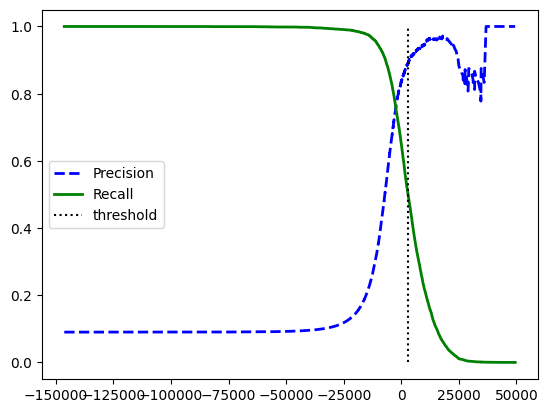

In [15]:
# plot precision and recall as functions of the threshold value
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.legend(loc='center left')
plt.show()

At this threshold value (3000), precision is near 90% and recall is around 50%.

In [16]:
# search for the lowest threshold that gives at least desired precision
# You can change the precision to be whatever you want
desired_precision = 0.90
idx_for_desired_precision = (precisions >= desired_precision).argmax()
threshold_for_desired_precision = thresholds[idx_for_desired_precision]

print(f'Desired Precision: {desired_precision}')
print(f'Threshold for Desired Precision: {threshold_for_desired_precision}')

# predict using the new threshold
y_train_pred_desired_precision = (y_scores >= threshold_for_desired_precision)
# check precision and recall for the new threshold
print(f'Precision: {precision_score(y_train_5, y_train_pred_desired_precision)}')
print(f'Recall: {recall_score(y_train_5, y_train_pred_desired_precision)}')
print(f'F1 Score: {f1_score(y_train_5, y_train_pred_desired_precision)}')


Desired Precision: 0.9
Threshold for Desired Precision: 3370.0194991439557
Precision: 0.9000345901072293
Recall: 0.4799852425751706
F1 Score: 0.6260827718960539


# The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool
used with binary classifiers. It is very similar to the precision/recall curve,
but instead of plotting precision versus recall, the ROC curve plots the
true positive rate (another name for recall) against the false positive rate
(FPR). 

The FPR (also called the fall-out) is the ratio of negative instances
that are incorrectly classified as positive. It is equal to 1 – the true
negative rate (TNR), which is the ratio of negative instances that are
correctly classified as negative. The TNR is also called *specificity*. 

Hence, the ROC curve plots *sensitivity* (recall) versus 1 – *specificity*.
To plot the ROC curve, you first use the `roc_curve()` function to
compute the TPR and FPR for various threshold values:

In [17]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

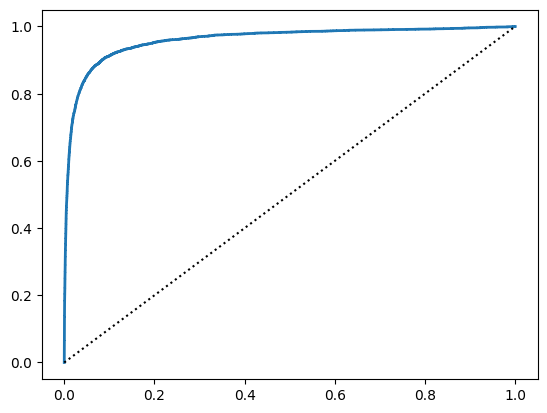

In [18]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false
positives (FPR) the classifier produces. The dotted line represents the
ROC curve of a purely random classifier; a good classifier stays as far
away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve
(AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a
purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn
provides a function to estimate the ROC AUC:

In [19]:
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

# STUDENT SECTION

In [31]:
# Create a 4-detector, a binary classifier, 
# capable of distinguishing between just two classes, 4 and not 4
y_train_4 = (y_train == '4')

# create target vectors for this classification task
# True for all 4s, False for all other digits
y_test_4 = (y_test == '4')


In [32]:
# Create a SGDClassifier and train it on the whole training set, please use a random state of 42
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_4)

SGDClassifier(random_state=42)

In [40]:
# Print the accuracy of your classifier using cross-validation with 3 folds
accuracy = cross_val_score(sgd_clf,
                           X_train, 
                           y_train_4,
                           cv=3,
                           scoring='accuracy')
accuracy

array([0.9671 , 0.97645, 0.9687 ])

In [41]:
# Get the predictions made on the training set using cross_val_predict()
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_4, cv=3)
y_train_pred

array([False, False,  True, ..., False, False, False])

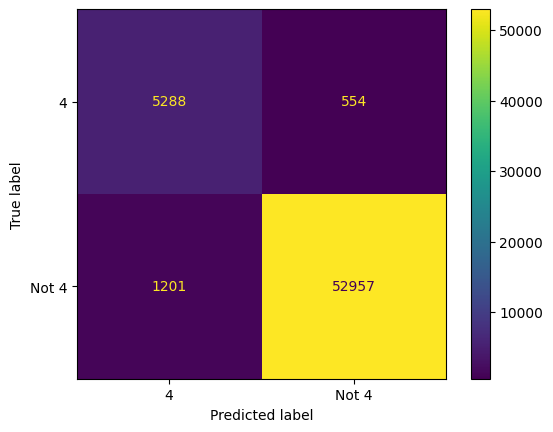

In [42]:
# Display your classifier's confusion matrix

cm = confusion_matrix(y_train_4, 
                      y_train_pred, 
                      labels=[True, False])
display = ConfusionMatrixDisplay(cm,
                                 display_labels=["4", "Not 4"])
display.plot()
plt.show()


In [43]:
# Print the precision, recall, and f1-score of the classifier 
print(precision_score(y_train_4, y_train_pred))
print(recall_score(y_train_4, y_train_pred))
print(f1_score(y_train_4, y_train_pred))



0.8149175527816305
0.905169462512838
0.8576757764982564


In [47]:
# compute decision scores for all instances in the training set using cross_val_predict with method='decision_function'
y_scores = cross_val_predict(sgd_clf, X_train, y_train_4, 
                  cv=3,
                  method='decision_function')
y_scores

array([-31754.76525516, -26393.82888302,   2160.11030898, ...,
       -19439.69962707, -10979.35873154, -22487.33775957])

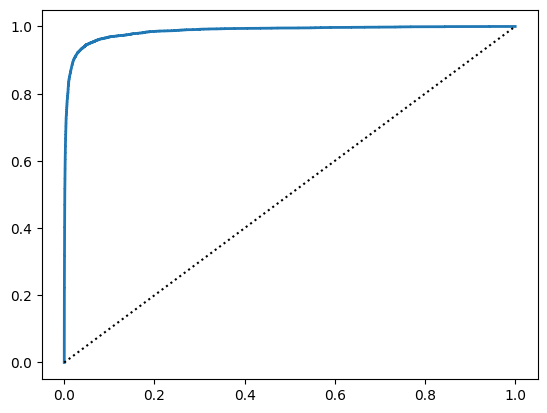

In [48]:
# Plot your classifier's roc curve and a random classifier's ROC curve
fpr, tpr, thresholds = roc_curve(y_train_4, y_scores)

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.show()


In [49]:
# Print the AUC value for your classifier's ROC
roc_auc_score(y_train_4, y_scores)

np.float64(0.9859276923382874)